# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("Acrobot-v1")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-09-23 19:09:29,932] Making new env: Acrobot-v1


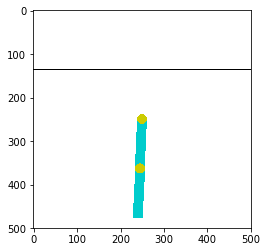

In [3]:
plt.imshow(env.render("rgb_array"))
del env

In [5]:
state_shape, n_actions

((6,), 3)

# Neural Network body

In [8]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)

dense_1 = DenseLayer(observation_layer, 250, nonlinearity=elu, name="dense_1") 
dense_2 = DenseLayer(dense_1, 300, nonlinearity=elu, name="dense_2")
dense_3 = DenseLayer(dense_2, 150, nonlinearity=elu, name="dense_3")

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(dense_3,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [10]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [12]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)


In [13]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[dense_1.W,
 dense_1.b,
 dense_2.W,
 dense_2.b,
 dense_3.W,
 dense_3.b,
 q-values.W,
 q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [14]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-09-23 19:37:21,043] Making new env: Acrobot-v1


In [15]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[1 1 2 1 0]]
rewards: [[-1. -1. -1. -1.  0.]]
Wall time: 589 ms


In [17]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH, append=True)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [19]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [21]:
qvalues_seq.eval().shape

(100, 10, 3)

In [20]:
replay.actions[0].eval()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 2, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0, 1, 1, 1, 2, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 2, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [2, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 2, 1, 1, 2],
       [1, 1, 1, 1, 2, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1,

In [22]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [23]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [24]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-09-23 20:05:04,816] Making new env: Acrobot-v1
[2017-09-23 20:05:04,821] Creating monitor directory ./records
[2017-09-23 20:05:04,827] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week4\records\openaigym.video.0.7388.video000000.mp4
[2017-09-23 20:05:14,837] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


Episode finished after 500 timesteps with reward=-500.0


In [25]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [26]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = -90

In [27]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|▍                                      | 99/10000 [00:13<20:39,  7.99it/s][2017-09-23 20:10:33,792] Making new env: Acrobot-v1
[2017-09-23 20:10:33,794] Clearing 4 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:10:34,634] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=100	epsilon=0.910
Current score(mean over 3) = -500.000


  2%|▊                                     | 199/10000 [00:27<21:13,  7.70it/s][2017-09-23 20:10:47,856] Making new env: Acrobot-v1
[2017-09-23 20:10:47,858] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 229 timesteps with reward=-228.0
Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:10:48,538] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=200	epsilon=0.828
Current score(mean over 3) = -409.333


  3%|█▏                                    | 299/10000 [00:41<21:42,  7.45it/s][2017-09-23 20:11:01,745] Making new env: Acrobot-v1
[2017-09-23 20:11:01,747] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:11:02,587] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=300	epsilon=0.754
Current score(mean over 3) = -500.000


  4%|█▌                                    | 399/10000 [00:55<21:38,  7.40it/s][2017-09-23 20:11:15,914] Making new env: Acrobot-v1
[2017-09-23 20:11:15,916] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 386 timesteps with reward=-385.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:11:16,661] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=400	epsilon=0.687
Current score(mean over 3) = -461.667


  5%|█▉                                    | 499/10000 [01:10<23:08,  6.84it/s][2017-09-23 20:11:30,919] Making new env: Acrobot-v1
[2017-09-23 20:11:30,923] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 307 timesteps with reward=-306.0
Episode finished after 266 timesteps with reward=-265.0
Episode finished after 226 timesteps with reward=-225.0


[2017-09-23 20:11:31,373] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=500	epsilon=0.626
Current score(mean over 3) = -265.333


  6%|██▎                                   | 599/10000 [01:25<21:52,  7.16it/s][2017-09-23 20:11:45,941] Making new env: Acrobot-v1
[2017-09-23 20:11:45,951] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 341 timesteps with reward=-340.0
Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:11:46,672] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=600	epsilon=0.571
Current score(mean over 3) = -446.667


  7%|██▋                                   | 699/10000 [01:41<22:34,  6.87it/s][2017-09-23 20:12:01,781] Making new env: Acrobot-v1
[2017-09-23 20:12:01,783] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 131 timesteps with reward=-130.0
Episode finished after 172 timesteps with reward=-171.0
Episode finished after 147 timesteps with reward=-146.0


[2017-09-23 20:12:02,072] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=700	epsilon=0.522
Current score(mean over 3) = -149.000


  8%|███                                   | 799/10000 [01:56<23:11,  6.61it/s][2017-09-23 20:12:16,999] Making new env: Acrobot-v1
[2017-09-23 20:12:17,004] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 471 timesteps with reward=-470.0
Episode finished after 157 timesteps with reward=-156.0
Episode finished after 308 timesteps with reward=-307.0


[2017-09-23 20:12:17,545] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=800	epsilon=0.477
Current score(mean over 3) = -311.000


  9%|███▍                                  | 899/10000 [02:12<27:28,  5.52it/s][2017-09-23 20:12:33,364] Making new env: Acrobot-v1
[2017-09-23 20:12:33,369] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 210 timesteps with reward=-209.0
Episode finished after 204 timesteps with reward=-203.0
Episode finished after 150 timesteps with reward=-149.0


[2017-09-23 20:12:33,772] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=900	epsilon=0.436
Current score(mean over 3) = -187.000


 10%|███▊                                  | 999/10000 [02:28<25:04,  5.98it/s][2017-09-23 20:12:49,310] Making new env: Acrobot-v1
[2017-09-23 20:12:49,317] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 174 timesteps with reward=-173.0
Episode finished after 208 timesteps with reward=-207.0
Episode finished after 183 timesteps with reward=-182.0


[2017-09-23 20:12:49,758] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1000	epsilon=0.399
Current score(mean over 3) = -187.333


 11%|████                                 | 1099/10000 [02:45<23:04,  6.43it/s][2017-09-23 20:13:06,055] Making new env: Acrobot-v1
[2017-09-23 20:13:06,057] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 225 timesteps with reward=-224.0
Episode finished after 500 timesteps with reward=-500.0
Episode finished after 146 timesteps with reward=-145.0


[2017-09-23 20:13:06,555] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1100	epsilon=0.366
Current score(mean over 3) = -289.667


 12%|████▍                                | 1199/10000 [03:02<23:27,  6.25it/s][2017-09-23 20:13:22,815] Making new env: Acrobot-v1
[2017-09-23 20:13:22,819] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 446 timesteps with reward=-445.0
Episode finished after 166 timesteps with reward=-165.0
Episode finished after 352 timesteps with reward=-351.0


[2017-09-23 20:13:23,370] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1200	epsilon=0.336
Current score(mean over 3) = -320.333


 13%|████▊                                | 1299/10000 [03:19<23:35,  6.15it/s][2017-09-23 20:13:39,821] Making new env: Acrobot-v1
[2017-09-23 20:13:39,825] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 161 timesteps with reward=-160.0
Episode finished after 114 timesteps with reward=-113.0
Episode finished after 130 timesteps with reward=-129.0


[2017-09-23 20:13:40,078] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1300	epsilon=0.309
Current score(mean over 3) = -134.000


 14%|█████▏                               | 1399/10000 [03:39<23:44,  6.04it/s][2017-09-23 20:13:59,834] Making new env: Acrobot-v1
[2017-09-23 20:13:59,838] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 118 timesteps with reward=-117.0
Episode finished after 122 timesteps with reward=-121.0
Episode finished after 96 timesteps with reward=-95.0


[2017-09-23 20:14:00,054] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1400	epsilon=0.284
Current score(mean over 3) = -111.000


 15%|█████▌                               | 1499/10000 [03:55<22:00,  6.44it/s][2017-09-23 20:14:16,052] Making new env: Acrobot-v1
[2017-09-23 20:14:16,056] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 272 timesteps with reward=-271.0
Episode finished after 157 timesteps with reward=-156.0
Episode finished after 156 timesteps with reward=-155.0


[2017-09-23 20:14:16,385] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1500	epsilon=0.262
Current score(mean over 3) = -194.000


 16%|█████▉                               | 1599/10000 [04:12<21:45,  6.43it/s][2017-09-23 20:14:33,315] Making new env: Acrobot-v1
[2017-09-23 20:14:33,317] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 377 timesteps with reward=-376.0
Episode finished after 331 timesteps with reward=-330.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:14:34,036] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1600	epsilon=0.242
Current score(mean over 3) = -402.000


 17%|██████▎                              | 1699/10000 [04:30<22:50,  6.06it/s][2017-09-23 20:14:51,262] Making new env: Acrobot-v1
[2017-09-23 20:14:51,264] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 143 timesteps with reward=-142.0
Episode finished after 194 timesteps with reward=-193.0
Episode finished after 116 timesteps with reward=-115.0


[2017-09-23 20:14:51,521] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1700	epsilon=0.224
Current score(mean over 3) = -150.000


 18%|██████▋                              | 1799/10000 [04:48<23:52,  5.73it/s][2017-09-23 20:15:08,855] Making new env: Acrobot-v1
[2017-09-23 20:15:08,861] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 125 timesteps with reward=-124.0
Episode finished after 102 timesteps with reward=-101.0
Episode finished after 84 timesteps with reward=-83.0


[2017-09-23 20:15:09,062] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1800	epsilon=0.207
Current score(mean over 3) = -102.667


 19%|███████                              | 1899/10000 [05:06<24:58,  5.41it/s][2017-09-23 20:15:27,396] Making new env: Acrobot-v1
[2017-09-23 20:15:27,400] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 206 timesteps with reward=-205.0
Episode finished after 136 timesteps with reward=-135.0
Episode finished after 127 timesteps with reward=-126.0


[2017-09-23 20:15:27,729] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=1900	epsilon=0.192
Current score(mean over 3) = -155.333


 20%|███████▍                             | 1999/10000 [05:25<23:43,  5.62it/s][2017-09-23 20:15:45,632] Making new env: Acrobot-v1
[2017-09-23 20:15:45,636] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 244 timesteps with reward=-243.0
Episode finished after 184 timesteps with reward=-183.0
Episode finished after 239 timesteps with reward=-238.0


[2017-09-23 20:15:46,051] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2000	epsilon=0.179
Current score(mean over 3) = -221.333


 21%|███████▊                             | 2099/10000 [05:43<23:34,  5.59it/s][2017-09-23 20:16:04,350] Making new env: Acrobot-v1
[2017-09-23 20:16:04,352] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 388 timesteps with reward=-387.0
Episode finished after 333 timesteps with reward=-332.0
Episode finished after 376 timesteps with reward=-375.0


[2017-09-23 20:16:05,066] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2100	epsilon=0.166
Current score(mean over 3) = -364.667


 22%|████████▏                            | 2199/10000 [06:04<23:16,  5.59it/s][2017-09-23 20:16:24,870] Making new env: Acrobot-v1
[2017-09-23 20:16:24,876] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 304 timesteps with reward=-303.0
Episode finished after 239 timesteps with reward=-238.0


[2017-09-23 20:16:25,467] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2200	epsilon=0.155
Current score(mean over 3) = -347.000


 23%|████████▌                            | 2299/10000 [06:22<23:52,  5.38it/s][2017-09-23 20:16:43,519] Making new env: Acrobot-v1
[2017-09-23 20:16:43,526] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 91 timesteps with reward=-90.0
Episode finished after 86 timesteps with reward=-85.0
Episode finished after 119 timesteps with reward=-118.0


[2017-09-23 20:16:43,714] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2300	epsilon=0.145
Current score(mean over 3) = -97.667


 24%|████████▉                            | 2399/10000 [06:40<22:29,  5.63it/s][2017-09-23 20:17:01,223] Making new env: Acrobot-v1
[2017-09-23 20:17:01,228] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 105 timesteps with reward=-104.0
Episode finished after 187 timesteps with reward=-186.0
Episode finished after 190 timesteps with reward=-189.0


[2017-09-23 20:17:01,513] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2400	epsilon=0.136
Current score(mean over 3) = -159.667


 25%|█████████▏                           | 2499/10000 [06:59<21:33,  5.80it/s][2017-09-23 20:17:19,881] Making new env: Acrobot-v1
[2017-09-23 20:17:19,885] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 104 timesteps with reward=-103.0
Episode finished after 83 timesteps with reward=-82.0
Episode finished after 98 timesteps with reward=-97.0


[2017-09-23 20:17:20,059] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2500	epsilon=0.128
Current score(mean over 3) = -94.000


 26%|█████████▌                           | 2599/10000 [07:17<22:53,  5.39it/s][2017-09-23 20:17:38,206] Making new env: Acrobot-v1
[2017-09-23 20:17:38,209] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 143 timesteps with reward=-142.0
Episode finished after 219 timesteps with reward=-218.0
Episode finished after 223 timesteps with reward=-222.0


[2017-09-23 20:17:38,576] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2600	epsilon=0.121
Current score(mean over 3) = -194.000


 27%|█████████▉                           | 2699/10000 [07:36<23:31,  5.17it/s][2017-09-23 20:17:56,723] Making new env: Acrobot-v1
[2017-09-23 20:17:56,727] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 153 timesteps with reward=-152.0
Episode finished after 114 timesteps with reward=-113.0
Episode finished after 167 timesteps with reward=-166.0


[2017-09-23 20:17:57,060] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2700	epsilon=0.114
Current score(mean over 3) = -143.667


 28%|██████████▎                          | 2799/10000 [07:55<23:49,  5.04it/s][2017-09-23 20:18:16,231] Making new env: Acrobot-v1
[2017-09-23 20:18:16,248] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 228 timesteps with reward=-227.0
Episode finished after 146 timesteps with reward=-145.0
Episode finished after 260 timesteps with reward=-259.0


[2017-09-23 20:18:16,662] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2800	epsilon=0.108
Current score(mean over 3) = -210.333


 29%|██████████▋                          | 2899/10000 [08:13<20:59,  5.64it/s][2017-09-23 20:18:34,482] Making new env: Acrobot-v1
[2017-09-23 20:18:34,488] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 111 timesteps with reward=-110.0
Episode finished after 109 timesteps with reward=-108.0
Episode finished after 96 timesteps with reward=-95.0


[2017-09-23 20:18:34,704] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=2900	epsilon=0.102
Current score(mean over 3) = -104.333


 30%|███████████                          | 2999/10000 [08:31<20:16,  5.76it/s][2017-09-23 20:18:52,479] Making new env: Acrobot-v1
[2017-09-23 20:18:52,485] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 87 timesteps with reward=-86.0
Episode finished after 89 timesteps with reward=-88.0
Episode finished after 109 timesteps with reward=-108.0


[2017-09-23 20:18:52,691] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3000	epsilon=0.097
Current score(mean over 3) = -94.000


 31%|███████████▍                         | 3099/10000 [08:49<19:05,  6.03it/s][2017-09-23 20:19:09,646] Making new env: Acrobot-v1
[2017-09-23 20:19:09,652] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 100 timesteps with reward=-99.0
Episode finished after 156 timesteps with reward=-155.0
Episode finished after 160 timesteps with reward=-159.0


[2017-09-23 20:19:09,893] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3100	epsilon=0.093
Current score(mean over 3) = -137.667


 32%|███████████▊                         | 3199/10000 [09:06<19:03,  5.95it/s][2017-09-23 20:19:26,770] Making new env: Acrobot-v1
[2017-09-23 20:19:26,774] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 129 timesteps with reward=-128.0
Episode finished after 476 timesteps with reward=-475.0
Episode finished after 150 timesteps with reward=-149.0


[2017-09-23 20:19:27,183] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3200	epsilon=0.089
Current score(mean over 3) = -250.667


 33%|████████████▏                        | 3299/10000 [09:23<18:19,  6.09it/s][2017-09-23 20:19:44,012] Making new env: Acrobot-v1
[2017-09-23 20:19:44,014] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 273 timesteps with reward=-272.0
Episode finished after 147 timesteps with reward=-146.0
Episode finished after 191 timesteps with reward=-190.0


[2017-09-23 20:19:44,340] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3300	epsilon=0.085
Current score(mean over 3) = -202.667


 34%|████████████▌                        | 3399/10000 [09:40<17:51,  6.16it/s][2017-09-23 20:20:00,874] Making new env: Acrobot-v1
[2017-09-23 20:20:00,878] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 171 timesteps with reward=-170.0
Episode finished after 270 timesteps with reward=-269.0
Episode finished after 167 timesteps with reward=-166.0


[2017-09-23 20:20:01,219] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3400	epsilon=0.082
Current score(mean over 3) = -201.667


 35%|████████████▉                        | 3499/10000 [09:57<18:05,  5.99it/s][2017-09-23 20:20:18,107] Making new env: Acrobot-v1
[2017-09-23 20:20:18,110] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 182 timesteps with reward=-181.0
Episode finished after 93 timesteps with reward=-92.0
Episode finished after 132 timesteps with reward=-131.0


[2017-09-23 20:20:18,346] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3500	epsilon=0.079
Current score(mean over 3) = -134.667


 36%|█████████████▎                       | 3599/10000 [10:14<17:56,  5.95it/s][2017-09-23 20:20:35,122] Making new env: Acrobot-v1
[2017-09-23 20:20:35,126] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 222 timesteps with reward=-221.0
Episode finished after 226 timesteps with reward=-225.0
Episode finished after 197 timesteps with reward=-196.0


[2017-09-23 20:20:35,488] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3600	epsilon=0.076
Current score(mean over 3) = -214.000


 37%|█████████████▋                       | 3699/10000 [10:31<16:56,  6.20it/s][2017-09-23 20:20:52,256] Making new env: Acrobot-v1
[2017-09-23 20:20:52,258] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 210 timesteps with reward=-209.0
Episode finished after 150 timesteps with reward=-149.0
Episode finished after 405 timesteps with reward=-404.0


[2017-09-23 20:20:52,656] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3700	epsilon=0.073
Current score(mean over 3) = -254.000


 38%|██████████████                       | 3799/10000 [10:48<17:26,  5.92it/s][2017-09-23 20:21:09,338] Making new env: Acrobot-v1
[2017-09-23 20:21:09,342] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 150 timesteps with reward=-149.0
Episode finished after 148 timesteps with reward=-147.0
Episode finished after 142 timesteps with reward=-141.0


[2017-09-23 20:21:09,590] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3800	epsilon=0.071
Current score(mean over 3) = -145.667


 39%|██████████████▍                      | 3899/10000 [11:05<16:59,  5.99it/s][2017-09-23 20:21:26,448] Making new env: Acrobot-v1
[2017-09-23 20:21:26,450] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 82 timesteps with reward=-81.0
Episode finished after 118 timesteps with reward=-117.0
Episode finished after 100 timesteps with reward=-99.0


[2017-09-23 20:21:26,620] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=3900	epsilon=0.069
Current score(mean over 3) = -99.000


 40%|██████████████▊                      | 3999/10000 [11:22<16:33,  6.04it/s][2017-09-23 20:21:43,452] Making new env: Acrobot-v1
[2017-09-23 20:21:43,454] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 435 timesteps with reward=-434.0
Episode finished after 148 timesteps with reward=-147.0
Episode finished after 257 timesteps with reward=-256.0


[2017-09-23 20:21:43,909] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4000	epsilon=0.067
Current score(mean over 3) = -279.000


 41%|███████████████▏                     | 4099/10000 [11:39<16:01,  6.14it/s][2017-09-23 20:22:00,474] Making new env: Acrobot-v1
[2017-09-23 20:22:00,476] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 115 timesteps with reward=-114.0
Episode finished after 100 timesteps with reward=-99.0
Episode finished after 75 timesteps with reward=-74.0


[2017-09-23 20:22:00,632] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4100	epsilon=0.066
Current score(mean over 3) = -95.667


 42%|███████████████▌                     | 4199/10000 [11:56<15:27,  6.25it/s][2017-09-23 20:22:17,274] Making new env: Acrobot-v1
[2017-09-23 20:22:17,280] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 79 timesteps with reward=-78.0
Episode finished after 116 timesteps with reward=-115.0
Episode finished after 150 timesteps with reward=-149.0


[2017-09-23 20:22:17,490] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4200	epsilon=0.064
Current score(mean over 3) = -114.000


 43%|███████████████▉                     | 4299/10000 [12:13<15:57,  5.96it/s][2017-09-23 20:22:34,285] Making new env: Acrobot-v1
[2017-09-23 20:22:34,287] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 155 timesteps with reward=-154.0
Episode finished after 144 timesteps with reward=-143.0
Episode finished after 141 timesteps with reward=-140.0


[2017-09-23 20:22:34,526] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4300	epsilon=0.063
Current score(mean over 3) = -145.667


 44%|████████████████▎                    | 4399/10000 [12:30<15:04,  6.19it/s][2017-09-23 20:22:51,212] Making new env: Acrobot-v1
[2017-09-23 20:22:51,214] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 207 timesteps with reward=-206.0
Episode finished after 260 timesteps with reward=-259.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:22:51,701] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4400	epsilon=0.062
Current score(mean over 3) = -321.667


 45%|████████████████▋                    | 4499/10000 [12:47<15:20,  5.98it/s][2017-09-23 20:23:08,300] Making new env: Acrobot-v1
[2017-09-23 20:23:08,302] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 384 timesteps with reward=-383.0
Episode finished after 194 timesteps with reward=-193.0
Episode finished after 402 timesteps with reward=-401.0


[2017-09-23 20:23:08,834] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4500	epsilon=0.061
Current score(mean over 3) = -325.667


 46%|█████████████████                    | 4599/10000 [13:05<15:14,  5.91it/s][2017-09-23 20:23:25,786] Making new env: Acrobot-v1
[2017-09-23 20:23:25,792] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 112 timesteps with reward=-111.0
Episode finished after 78 timesteps with reward=-77.0
Episode finished after 105 timesteps with reward=-104.0


[2017-09-23 20:23:25,966] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4600	epsilon=0.060
Current score(mean over 3) = -97.333


 47%|█████████████████▍                   | 4699/10000 [13:22<14:46,  5.98it/s][2017-09-23 20:23:42,770] Making new env: Acrobot-v1
[2017-09-23 20:23:42,775] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 161 timesteps with reward=-160.0
Episode finished after 189 timesteps with reward=-188.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:23:43,258] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4700	epsilon=0.059
Current score(mean over 3) = -282.667


 48%|█████████████████▊                   | 4799/10000 [13:39<14:37,  5.93it/s][2017-09-23 20:23:59,935] Making new env: Acrobot-v1
[2017-09-23 20:23:59,941] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 393 timesteps with reward=-392.0
Episode finished after 320 timesteps with reward=-319.0
Episode finished after 366 timesteps with reward=-365.0


[2017-09-23 20:24:00,579] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4800	epsilon=0.058
Current score(mean over 3) = -358.667


 49%|██████████████████▏                  | 4899/10000 [13:56<13:41,  6.21it/s][2017-09-23 20:24:17,379] Making new env: Acrobot-v1
[2017-09-23 20:24:17,381] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 128 timesteps with reward=-127.0
Episode finished after 97 timesteps with reward=-96.0
Episode finished after 237 timesteps with reward=-236.0


[2017-09-23 20:24:17,631] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=4900	epsilon=0.057
Current score(mean over 3) = -153.000


 50%|██████████████████▍                  | 4999/10000 [14:14<14:14,  5.85it/s][2017-09-23 20:24:34,677] Making new env: Acrobot-v1
[2017-09-23 20:24:34,681] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 219 timesteps with reward=-218.0
Episode finished after 301 timesteps with reward=-300.0
Episode finished after 444 timesteps with reward=-443.0


[2017-09-23 20:24:35,357] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5000	epsilon=0.056
Current score(mean over 3) = -320.333


 51%|██████████████████▊                  | 5099/10000 [14:31<14:00,  5.83it/s][2017-09-23 20:24:52,159] Making new env: Acrobot-v1
[2017-09-23 20:24:52,163] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 254 timesteps with reward=-253.0
Episode finished after 355 timesteps with reward=-354.0
Episode finished after 313 timesteps with reward=-312.0


[2017-09-23 20:24:52,663] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5100	epsilon=0.056
Current score(mean over 3) = -306.333


 52%|███████████████████▏                 | 5199/10000 [14:48<13:50,  5.78it/s][2017-09-23 20:25:09,295] Making new env: Acrobot-v1
[2017-09-23 20:25:09,299] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 364 timesteps with reward=-363.0
Episode finished after 289 timesteps with reward=-288.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:25:09,940] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5200	epsilon=0.055
Current score(mean over 3) = -383.667


 53%|███████████████████▌                 | 5299/10000 [15:06<13:17,  5.89it/s][2017-09-23 20:25:26,912] Making new env: Acrobot-v1
[2017-09-23 20:25:26,915] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 152 timesteps with reward=-151.0
Episode finished after 125 timesteps with reward=-124.0
Episode finished after 176 timesteps with reward=-175.0


[2017-09-23 20:25:27,161] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5300	epsilon=0.055
Current score(mean over 3) = -150.000


 54%|███████████████████▉                 | 5399/10000 [15:23<12:23,  6.19it/s][2017-09-23 20:25:43,850] Making new env: Acrobot-v1
[2017-09-23 20:25:43,855] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 197 timesteps with reward=-196.0
Episode finished after 159 timesteps with reward=-158.0
Episode finished after 184 timesteps with reward=-183.0


[2017-09-23 20:25:44,150] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5400	epsilon=0.054
Current score(mean over 3) = -179.000


 55%|████████████████████▎                | 5499/10000 [15:40<12:20,  6.08it/s][2017-09-23 20:26:00,833] Making new env: Acrobot-v1
[2017-09-23 20:26:00,839] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 130 timesteps with reward=-129.0
Episode finished after 128 timesteps with reward=-127.0
Episode finished after 119 timesteps with reward=-118.0


[2017-09-23 20:26:01,059] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5500	epsilon=0.054
Current score(mean over 3) = -124.667


 56%|████████████████████▋                | 5599/10000 [15:57<12:36,  5.82it/s][2017-09-23 20:26:17,658] Making new env: Acrobot-v1
[2017-09-23 20:26:17,662] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 475 timesteps with reward=-474.0
Episode finished after 498 timesteps with reward=-497.0
Episode finished after 356 timesteps with reward=-355.0


[2017-09-23 20:26:18,411] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5600	epsilon=0.054
Current score(mean over 3) = -442.000


 57%|█████████████████████                | 5699/10000 [16:14<12:01,  5.96it/s][2017-09-23 20:26:35,344] Making new env: Acrobot-v1
[2017-09-23 20:26:35,348] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 375 timesteps with reward=-374.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:26:36,093] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5700	epsilon=0.053
Current score(mean over 3) = -458.000


 58%|█████████████████████▍               | 5799/10000 [16:32<11:14,  6.23it/s][2017-09-23 20:26:52,800] Making new env: Acrobot-v1
[2017-09-23 20:26:52,802] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 78 timesteps with reward=-77.0
Episode finished after 104 timesteps with reward=-103.0
Episode finished after 116 timesteps with reward=-115.0


[2017-09-23 20:26:52,975] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5800	epsilon=0.053
Current score(mean over 3) = -98.333


 59%|█████████████████████▊               | 5899/10000 [16:49<11:55,  5.73it/s][2017-09-23 20:27:09,985] Making new env: Acrobot-v1
[2017-09-23 20:27:09,989] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 170 timesteps with reward=-169.0
Episode finished after 176 timesteps with reward=-175.0
Episode finished after 209 timesteps with reward=-208.0


[2017-09-23 20:27:10,296] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=5900	epsilon=0.053
Current score(mean over 3) = -184.000


 60%|██████████████████████▏              | 5999/10000 [17:06<10:52,  6.13it/s][2017-09-23 20:27:27,241] Making new env: Acrobot-v1
[2017-09-23 20:27:27,245] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 163 timesteps with reward=-162.0
Episode finished after 500 timesteps with reward=-500.0


[2017-09-23 20:27:27,868] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=6000	epsilon=0.052
Current score(mean over 3) = -387.333


 61%|██████████████████████▌              | 6099/10000 [17:24<11:00,  5.91it/s][2017-09-23 20:27:44,942] Making new env: Acrobot-v1
[2017-09-23 20:27:44,946] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 160 timesteps with reward=-159.0
Episode finished after 246 timesteps with reward=-245.0
Episode finished after 411 timesteps with reward=-410.0


[2017-09-23 20:27:45,400] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=6100	epsilon=0.052
Current score(mean over 3) = -271.333


 62%|██████████████████████▉              | 6199/10000 [17:41<10:40,  5.93it/s][2017-09-23 20:28:02,277] Making new env: Acrobot-v1
[2017-09-23 20:28:02,279] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 62 timesteps with reward=-61.0
Episode finished after 86 timesteps with reward=-85.0
Episode finished after 108 timesteps with reward=-107.0


[2017-09-23 20:28:02,430] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


iter=6200	epsilon=0.052
Current score(mean over 3) = -84.333
You win!


C:\ProgramData\Anaconda3\envs\rl_practice\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


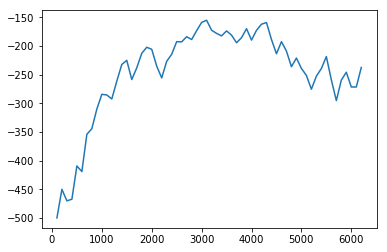

In [30]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(), key=lambda k:k[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [31]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-09-23 21:17:03,773] Making new env: Acrobot-v1
[2017-09-23 21:17:03,778] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-09-23 21:17:03,783] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week4\records\openaigym.video.63.7388.video000000.mp4


Episode finished after 81 timesteps with reward=-80.0


[2017-09-23 21:17:05,454] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week4\records\openaigym.video.63.7388.video000001.mp4


Episode finished after 79 timesteps with reward=-78.0
Episode finished after 95 timesteps with reward=-94.0
Episode finished after 110 timesteps with reward=-109.0
Episode finished after 75 timesteps with reward=-74.0
Episode finished after 80 timesteps with reward=-79.0
Episode finished after 110 timesteps with reward=-109.0
Episode finished after 98 timesteps with reward=-97.0


[2017-09-23 21:17:07,278] Starting new video recorder writing to C:\Users\1\Documents\RL_practice\Practical_RL\week4\records\openaigym.video.63.7388.video000008.mp4


Episode finished after 71 timesteps with reward=-70.0
Episode finished after 77 timesteps with reward=-76.0


[2017-09-23 21:17:08,631] Finished writing results. You can upload them to the scoreboard via gym.upload('C:\\Users\\1\\Documents\\RL_practice\\Practical_RL\\week4\\records')


average reward: [-80.0, -78.0, -94.0, -109.0, -74.0, -79.0, -109.0, -97.0, -70.0, -76.0]


In [32]:
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

## Homework part I (5+ pts)

Train a neural network for [`LunarLander-v2`](https://gym.openai.com/envs/LunarLander-v2).
* Getting average reward of at least +0 gets you 5 points
* Higher reward = more points


## Bonus I
* Try getting the same [or better] results on Acrobot __(+2 pts)__ or __LunarLander (+3 pts)__ using on-policy methods
* You can get n-step q-learning by messing with ```n_steps``` param in the q-learning code above
* Note that using large experience replay buffer will slow down on-policy algorithms to almost zero, so it's probably a good idea to use small experience replay buffer with several parallel agents